[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yhtang/FunFact/blob/master/docs/examples/matrix-approximation.ipynb)

# Matrix Approximation

In [ ]:
# Uncomment below if running on Colab

# !pip install funfact scikit-image

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import funfact as ff

In [3]:
ff.use('jax')

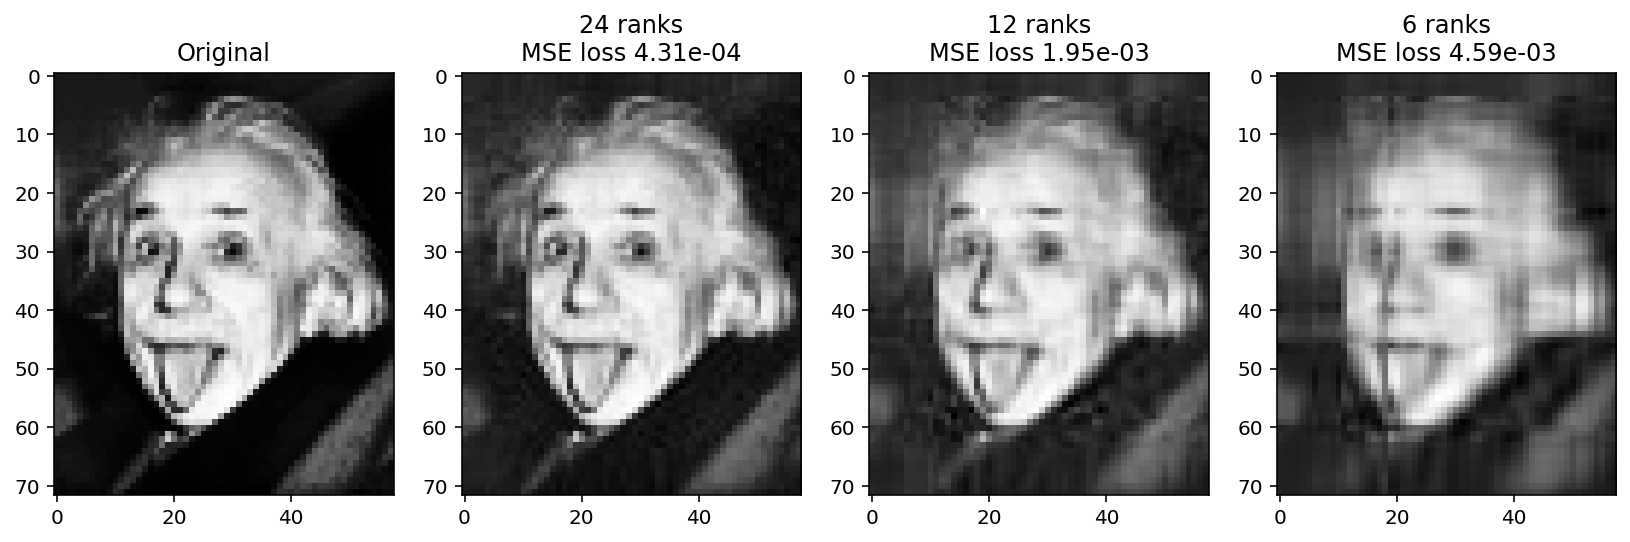

In [4]:
img = ski.transform.rescale(ski.io.imread('Einstein_tongue.jpg'), 0.25, anti_aliasing=True)
img **= 1.8  # gamma correction

ranks = [24, 12, 6]
U, S, V = np.linalg.svd(img)
img_svd = []
for r in ranks:
    img_svd.append((U[:, :r] * S[:r]) @ V[:r, :])


fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='Greys_r')
axs[0].set_title('Original')

for r, img_compressed, ax in zip(ranks, img_svd, axs[1:]):
    ax.imshow(img_compressed, cmap='Greys_r')
    ax.set_title('{} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse_loss(img_compressed, img)))

plt.show()

SVD by SGD


100%|██████████| 1000/1000 [00:01<00:00, 695.06it/s]


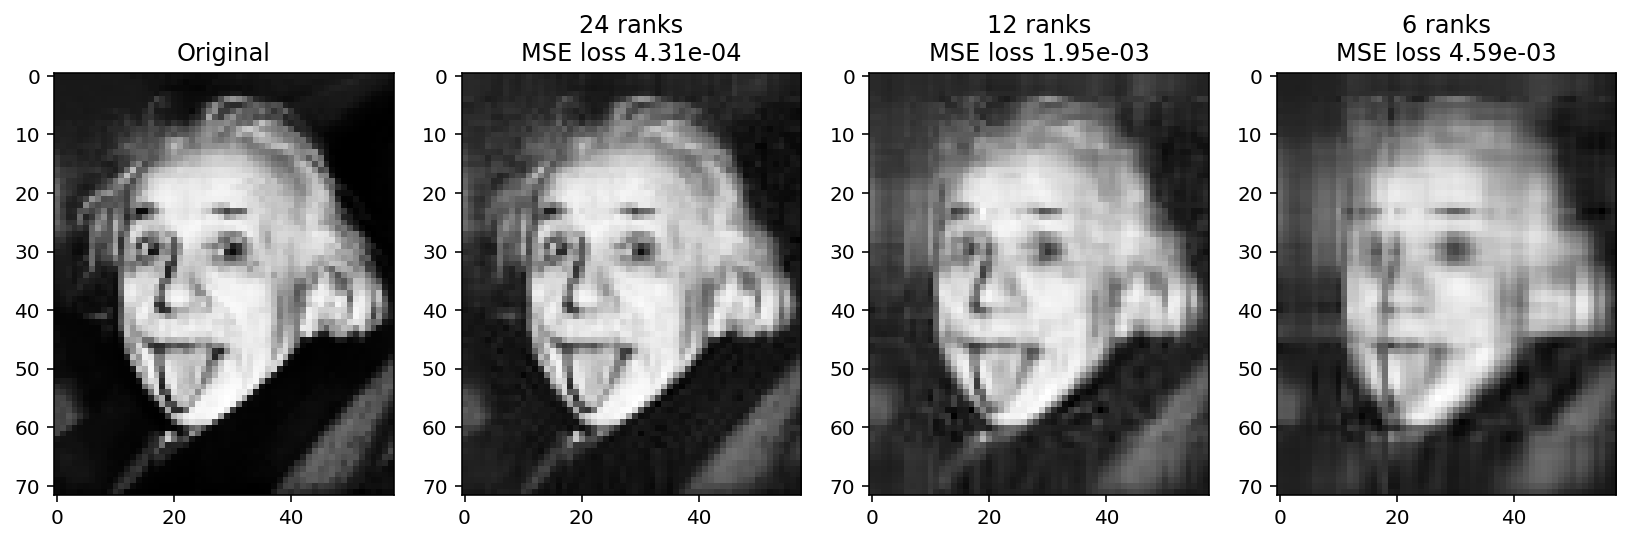

In [12]:
n, m = img.shape

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='Greys_r')
axs[0].set_title('Original')

print('SVD by SGD')

for r, ax in zip(ranks, axs[1:]):
    u = ff.tensor('u', n, r, initializer=ff.initializers.Normal)
    v = ff.tensor('v', m, r, initializer=ff.initializers.Normal)
    i, j, k = ff.indices('i, j, k')
    tsrex = u[i, j] * v[k, j]
    fac = ff.factorize(tsrex, img, lr=0.1, max_steps=1000)
    img_compressed = fac()
    ax.imshow(img_compressed, cmap='Greys_r')
    ax.set_title('{} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse_loss(img_compressed, img)))

plt.show()
tsrex

NMF by SGD


100%|██████████| 10000/10000 [00:15<00:00, 626.43it/s]


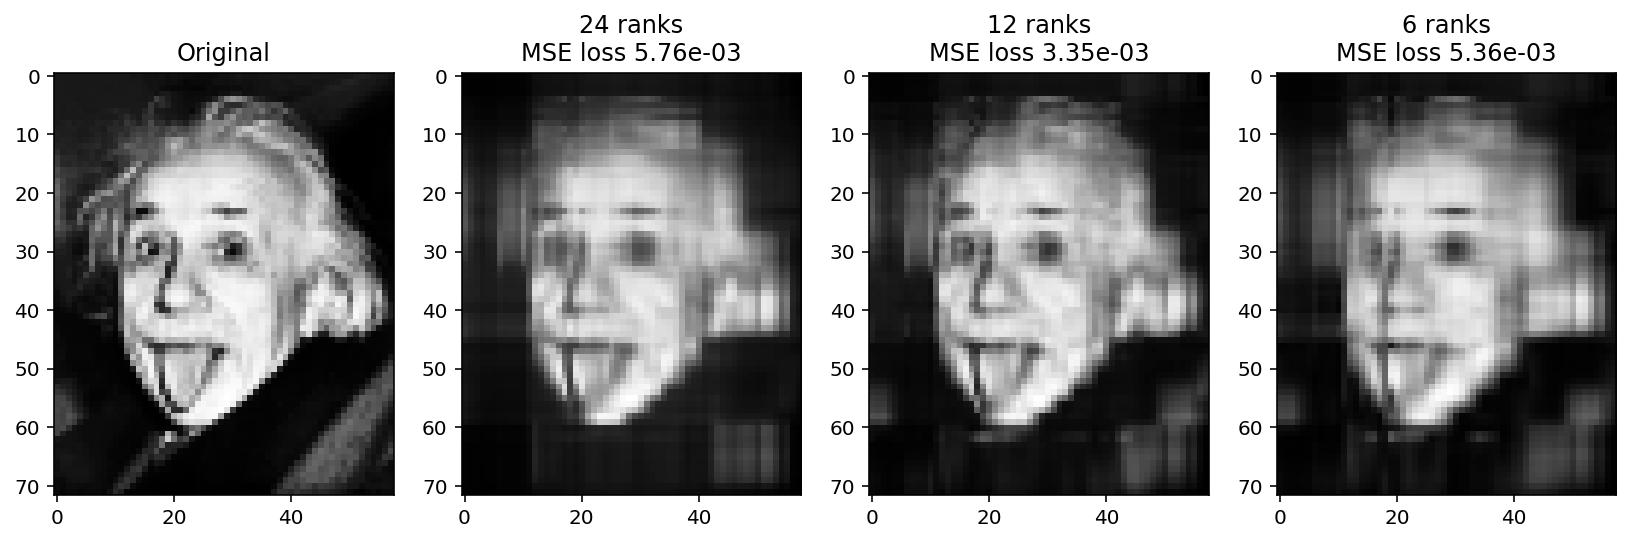

In [18]:
n, m = img.shape

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='Greys_r')
axs[0].set_title('Original')

print('NMF by SGD')

for r, ax in zip(ranks, axs[1:]):
    u = ff.tensor('u', n, r, initializer=ff.initializers.Normal)
    v = ff.tensor('v', m, r, initializer=ff.initializers.Normal)
    i, j, k = ff.indices('i, j, k')
    tsrex = ff.exp(u[i, j]) * ff.exp(v[k, j])
    fac = ff.factorize(tsrex, img, nvec=64, lr=1e-4, max_steps=10000)
    img_compressed = fac()
    ax.imshow(img_compressed, cmap='Greys_r')
    ax.set_title('{} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse_loss(img_compressed, img)))

plt.show()
tsrex

RBF by SGD


100%|██████████| 10000/10000 [00:32<00:00, 304.48it/s]


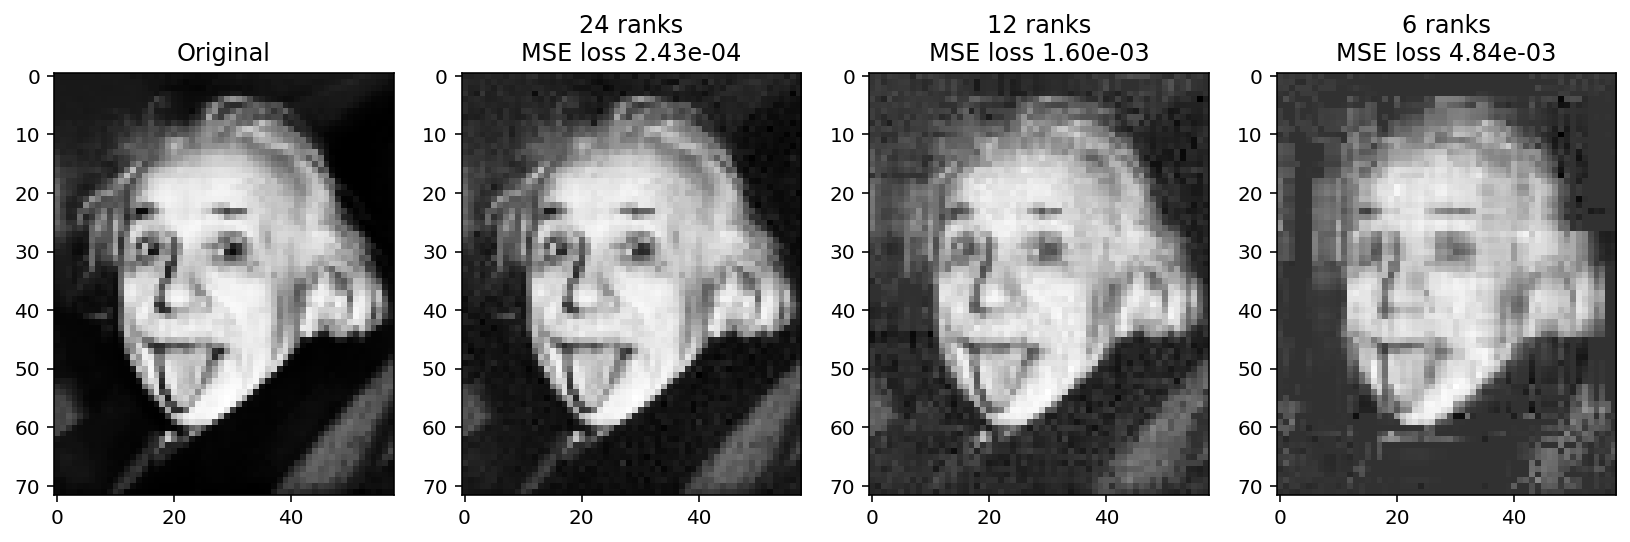

In [17]:
n, m = img.shape

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='Greys_r')
axs[0].set_title('Original')

print('RBF by SGD')

for r, ax in zip(ranks, axs[1:]):
    u = ff.tensor('u', n, r, initializer=ff.initializers.Normal)
    v = ff.tensor('v', m, r, initializer=ff.initializers.Normal)
    a = ff.tensor('a', r, initializer=ff.initializers.VarianceScaling(scale=np.var(img), axis=0))
    b = ff.tensor('b')
    i, j, k = ff.indices('i, j, k')
    tsrex = ff.exp(-(u[i, ~k] - v[j, ~k])**2) * a[k] + b[[]]
    fac = ff.factorize(tsrex, img, nvec=8, max_steps=10000)
    img_compressed = fac()
    ax.imshow(img_compressed, cmap='Greys_r')
    ax.set_title('{} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse_loss(img_compressed, img)))

plt.show()
tsrex

---